##### This notebook contains code for getting statistic indices after ML and plotting them 
##### Chronological age

### Load libraries

In [2]:
## IMPORTANT !

# In the first order need to set the number of CPU 
# for calculation before launching (depends on computer's number of cores)
n_jobs= 30

#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

In [3]:
#load path to orig tables
path='/media/data/HCPAging/data/MLTablesMultCon/'

In [4]:
#load some features tables as dictionary
features = {
    'carit1':pd.read_csv(path+'carit-con1.csv', index_col=0),
    'surf':pd.read_csv(path+'surf.csv', index_col=0),
    'subc':pd.read_csv(path+'subc.csv', index_col=0),
    'VolBrain':pd.read_csv(path+'VolBrain.csv', index_col=0),
    
    'rest':pd.read_csv(path+'rest_hpass.csv', index_col=0) 

}


In [5]:
#load labels from orig tables
ind_task = features['carit1'].columns.values
ind_anat = features['surf'].columns.values
ind_subc = features['subc'].columns.values
ind_bVol = features['VolBrain'].columns.values
ind_FC = features['rest'].columns.values

### CV stats

In [7]:
#path to ML outputs
nmf='/media/data/HCPAging/data/MLTablesMultCon/output_5cv_sexAdj_noStdTarg_STDstackFeatures/output_5cv_sexAdj_noStdTarg_STDstackFeatures_interview_age'
path2 = nmf+'/'

#read number of folds
folders = sorted((os.listdir(path2)))[:5]
print(path2)
print(folders)

/media/data/HCPAging/data/MLTablesMultCon/output_5cv_sexAdj_noStdTarg_STDstackFeatures/output_5cv_sexAdj_noStdTarg_STDstackFeatures_interview_age/
['Fold_0', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4']


In [8]:
#Labels
#labels for single modalities and stack
lblY = ['CARIT: NoGo-Go',
'CARIT: Go',
'CARIT: NoGo',
'FACENAME: Encoding',
'FACENAME: Recall',
'FACENAME: Distractor',
'FACENAME: Encoding-Recall',
'FACENAME: Encoding-Distractor',
'FACENAME: Recall-Distractor',
'VISMOTOR: Vismotor',
'CARIT: FC',
'FACE-NAME: FC',
'VISUAL MOTOR: FC',
'Cortical Thickness',
'Cortical Surface',
'Subcortical Volume',
'Total Brain Volume',
'Resting State FC',
'Stacked: All', #set1
'Stacked: Task Contrast', #set2
'Stacked: Non Task', #set3
'Stacked: Task FC', #set4
'Stacked: Task Contrast & FC', #set5
'Stacked: All excluding Task FC', #set6  with Task GLM
'Stacked: All excluding Task Contrast',  #set7 with Task FC
'Stacked: Resting and Task FC'] #set8

#labels for single modalities within each stack
lbl_set1 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism', 
            'carit_FC', 'face_FC', 'vism_FC', 
            'cort', 'surf', 'subc', 'VolBrain', 'rest']

lbl_set2 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism']
lbl_set3 = ['cort', 'subc', 'surf', 'rest', 'VolBrain']

lbl_set4 = ['carit_FC', 'face_FC', 'vism_FC']
lbl_set5 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism', 
            'carit_FC', 'face_FC', 'vism_FC']
lbl_set6 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism', 
            'cort', 'subc', 'surf', 'rest', 'VolBrain']
lbl_set7 = ['carit_FC', 'face_FC', 'vism_FC', 'cort', 
            'subc', 'surf', 'rest', 'VolBrain']
lbl_set8 = ['carit_FC', 'face_FC', 'vism_FC', 'rest']



In [9]:
#for train subset

#assamble y_pred from all folds into one table

#open dict for storing results
dt_ypred_all = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/2level_test1_y_pred_singleML.csv', index_col=0)
    df2 = pd.read_csv(path2+fold+'/2level_test1_y_pred_stacked.csv', index_col=0)
    yrl = pd.read_csv(path2+fold+'/target_y_train2.csv', index_col=0, squeeze=True)
    #concat all in one for one fold
    df_y_rp = pd.concat([df1,df2], axis=1)
    df_y_rp['y_real'] = yrl
    df_y_rp['fold'] = np.full(len(yrl), fold[-1], dtype=int)
    #write to dict
    dt_ypred_all[fold] = df_y_rp
    
#transform dict to one table
df_y_all = dt_ypred_all[folders[0]]
for fold in folders[1:]:
    df_y_all = pd.concat([df_y_all, dt_ypred_all[fold]], axis=0)
#save
df_y_all.to_csv(path2+'all_fold_y-pred_y-obs_train.csv')

In [10]:
#for test subset

#assamble y_pred from all folds into one table

#open dict for storing results
dt_ypred_all = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/3level_test2_y_pred_singleML.csv', index_col=0)
    df2 = pd.read_csv(path2+fold+'/3level_test2_y_pred_stacked.csv', index_col=0)
    yrl = pd.read_csv(path2+fold+'/target_y_test.csv', index_col=0, squeeze=True)
    #yrl.index.name = None
    #concat all in one for one fold
    df_y_rp = pd.concat([df1,df2], axis=1)
    df_y_rp['y_real'] = yrl
    df_y_rp['fold'] = np.full(len(yrl), fold[-1], dtype=int)
    #write to dict
    dt_ypred_all[fold] = df_y_rp
    
#transform dict to one table
df_y_all = dt_ypred_all[folders[0]]
for fold in folders[1:]:
    df_y_all = pd.concat([df_y_all, dt_ypred_all[fold]], axis=0)
#save
df_y_all.to_csv(path2+'all_fold_y-pred_y-obs.csv')

In [11]:
#assamble performance indexes into separete tables and save

#open dict for storing fold's results
dt_r2 = {}
dt_mse = {}
dt_mae = {}
dt_cor = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/3level_test2_perf_elnet.csv', index_col=0) 
    df2 = pd.read_csv(path2+fold+'/3level_test2_perf_stacked.csv', index_col=0)
    df_p = pd.concat([df1, df2], axis=1)
    #assign to dict
    dt_r2[fold] = df_p.iloc[0,:]
    dt_mse[fold] = df_p.iloc[1,:]
    dt_mae[fold] = df_p.iloc[2,:]
    dt_cor[fold] = df_p.iloc[3,:]
#transfrom dict to tables
df_r2 = pd.DataFrame(dt_r2).T
df_mse = pd.DataFrame(dt_mse).T
df_mae = pd.DataFrame(dt_mae).T
df_cor = pd.DataFrame(dt_cor).T
#and save these tables
df_r2.to_csv(path2+'r2_all_fold_cv_perf.csv')
df_mse.to_csv(path2+'mse_all_fold_cv_perf.csv')
df_mae.to_csv(path2+'mae_all_fold_cv_perf.csv')
df_cor.to_csv(path2+'cor_all_fold_cv_perf.csv')

In [12]:
#creating table of mean cv performance


df_mper = pd.DataFrame({'r2' : df_r2.mean(),
                       'mse' : df_mse.mean(),
                       'mae' : df_mae.mean(),
                       'cor' : df_cor.mean()})
#df_mper.index = lblY

#save it
df_mper.to_csv(path2+'mean_cv_perf.csv')

#display sorting by r2
print('Mean CV Performance')
display(df_mper.sort_values(by='r2', ascending=False))

Mean CV Performance


r2           mse         mae       cor
set7      0.765319   6684.523881   63.469689  0.880865
set3      0.763492   6732.991570   64.389395  0.878609
set1      0.750487   7138.525476   64.875519  0.876319
set6      0.749106   7186.403574   65.014484  0.875437
cort      0.687414   8948.249950   73.823127  0.831582
set8      0.577932  12065.916435   87.210481  0.772927
set5      0.573229  12224.677194   86.649475  0.768940
subc      0.565554  12392.541968   88.019531  0.762452
VolBrain  0.556143  12761.113141   89.935320  0.751153
rest      0.520582  13802.652604   94.468299  0.738934
set4      0.518876  13810.427539   93.044216  0.737756
set2      0.513021  13966.848153   93.269585  0.726589
carit_FC  0.453046  15743.463439  101.595752  0.701554
face_FC   0.438320  16171.797024  102.335236  0.697719
vism_FC   0.383962  17901.682626  108.169215  0.656726
face5     0.342935  18802.930110  109.035767  0.598287
face6     0.292384  20291.299135  115.690906  0.555503
face2     0.281070  20785.553211  115.477793  0.540380
surf      0.274741  20878.685401  117.855836  0.556316
vism      0.267745  20962.858843  116.333616  0.547333
face1     0.249393  21646.356521  120.488154  0.508423
carit3    0.239100  21935.853454  120.137714  0.518705
face3     0.197223  23272.152478  123.361890  0.449097
face4     0.137885  24862.208106  128.811458  0.403964
carit4    0.136083  24913.039421  127.974348  0.387688
carit1    0.092346  26339.522593  133.560342  0.323628

In [13]:
#creating table of std cv performance
df_stper = pd.DataFrame({'r2' : df_r2.std(),
                       'mse' : df_mse.std(),
                       'mae' : df_mae.std(),
                       'cor' : df_cor.std()})
#df_stper.index = lblY

#save it
df_stper.to_csv(path2+'mean_cv_perf_stDev.csv')

#display sorting by r2
print('StD of CV Performance')
display(df_stper.loc[(df_mper.sort_values(by='r2', ascending=False)).index, :])

StD of CV Performance


r2          mse        mae       cor
set7      0.030622   390.142667   3.106256  0.022471
set3      0.036181   590.267652   4.180540  0.024044
set1      0.026447   603.051662   2.386477  0.019014
set6      0.024159   641.696037   2.478509  0.017766
cort      0.034930   945.311089   4.908670  0.020492
set8      0.060583  1393.922756   5.921174  0.042572
set5      0.064231  1664.982745   5.868681  0.045410
subc      0.064990  1223.300291   3.165071  0.047908
VolBrain  0.027820  1419.297357   2.943597  0.018999
rest      0.052682  2208.483075   7.342565  0.037880
set4      0.053521  1670.690271   6.914039  0.042282
set2      0.068353  1946.075583   5.516820  0.044487
carit_FC  0.033567  1878.941990   5.544001  0.037278
face_FC   0.046569  2156.577398   8.400017  0.056059
vism_FC   0.041832  3661.981099  11.247795  0.025617
face5     0.088483  2406.847471   8.537594  0.073495
face6     0.057312  1830.057699   3.475364  0.054994
face2     0.041342  3328.868154   7.599006  0.037797
surf      0.083482  3280.276715   9.037273  0.078662
vism      0.065127  1548.642572   3.592271  0.088156
face1     0.080678  3803.189505   8.188638  0.075278
carit3    0.068708  3239.323296   9.443245  0.067469
face3     0.058049  4418.274032  10.262654  0.062720
face4     0.036112  3346.255922   7.683415  0.048080
carit4    0.071197  3604.426696   9.653319  0.092448
carit1    0.077811  5269.850375  13.149692  0.130795

### Bootstrapping

In [14]:
#bootstrapping
i=0
#empty dict for storing indexes after each trial
dt_boot={}
while i<5000: #number of trials (shuffles)
    #shuffle
    boot = resample(df_y_all, replace=True, n_samples=len(df_y_all.index), random_state=i)
    #calculate indexes for this trial
    cor, r2, mse, mae, cols = [], [], [], [], []
    for col in boot.columns[0:-2]:
        corr, _ = pearsonr(boot['y_real'], boot[col])
        cor += [corr]
        r2 += [r2_score(boot['y_real'], boot[col])]
        mse += [mean_squared_error(boot['y_real'], boot[col])]
        mae += [mean_absolute_error(boot['y_real'], boot[col])]
        cols +=[col]
    #write it to dict
    dt_boot[i] = pd.DataFrame({'r2':r2, 'mse':mse, 'mae':mae, 'cor':cor}, index = cols)
    i+=1

#transform dict to mo convenient tables sorted by type of index
#empty dict
dbt_r2 = {}
dbt_mse = {}
dbt_mae = {}
dbt_cor = {}
#aassign each index to own dict
for key in dt_boot.keys():
    dbt_r2[key] = dt_boot[key].iloc[:,0]
    dbt_mse[key] = dt_boot[key].iloc[:,1]
    dbt_mae[key] = dt_boot[key].iloc[:,2]
    dbt_cor[key] = dt_boot[key].iloc[:,3]
#transform to tables
bt_r2 = pd.DataFrame(dbt_r2).T
bt_mse = pd.DataFrame(dbt_mse).T
bt_mae = pd.DataFrame(dbt_mae).T
bt_cor = pd.DataFrame(dbt_cor).T
#save tables
bt_r2.to_csv(path2+'r2_bootstrap.csv')
bt_mse.to_csv(path2+'mse_bootstrap.csv')
bt_mae.to_csv(path2+'mae_bootstrap.csv')
bt_cor.to_csv(path2+'cor_bootstrap.csv')

#create table with mean performance
bt_mean = pd.DataFrame({'r2': np.array(bt_r2.mean()),
                        'mse': np.array(bt_mse.mean()),
                        'mae': np.array(bt_mae.mean()),
                        'cor': np.array(bt_cor.mean()),
                             }, index = bt_r2.columns)
#bt_mean.index = lblY
#save mean table
bt_mean.to_csv(path2+'mean_boot_perf.csv')

#display
print('Mean Performance based on Bootstrapping of Predicted and Observed Values across Test Folds')
display(bt_mean.sort_values(by='r2', ascending=False))

Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


r2           mse         mae       cor
set7      0.769824   6685.701305   63.504974  0.879433
set3      0.768153   6733.436778   64.424267  0.877679
set1      0.754396   7135.743594   64.869710  0.874568
set6      0.752761   7183.211233   65.006188  0.873493
cort      0.691964   8945.551959   73.823786  0.832448
set8      0.584668  12065.541459   87.217995  0.766962
set5      0.579590  12214.894686   86.597201  0.765020
subc      0.573475  12387.551416   88.020160  0.758139
VolBrain  0.560355  12768.709475   89.969823  0.749550
rest      0.525503  13789.309948   94.429243  0.735657
set4      0.524812  13806.819853   93.040227  0.727085
set2      0.519720  13953.270828   93.198498  0.722441
carit_FC  0.458640  15736.800084  101.579073  0.694355
face_FC   0.444304  16152.861555  102.273199  0.686819
vism_FC   0.385187  17873.908278  108.107356  0.632174
face5     0.353810  18780.481545  108.941315  0.596282
face6     0.302570  20268.695461  115.606031  0.552107
face2     0.285829  20756.561581  115.411602  0.537012
surf      0.281701  20880.310658  117.877576  0.533132
vism      0.279189  20951.753592  116.281453  0.530192
face1     0.256287  21615.520189  120.432724  0.508852
carit3    0.245730  21928.763097  120.113281  0.498425
face3     0.201564  23213.103431  123.190785  0.451795
face4     0.146159  24821.523079  128.682764  0.385699
carit4    0.144490  24868.487038  127.852219  0.382812
carit1    0.095505  26299.146878  133.462054  0.313529

### Plotting

### Feature coefficients order within models

#### Feature coefficients for stacked modality models

In [15]:
#extract feature importance from saved models

dct_stack_coeff={} #empty dct to store 

nsets = ['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8']
lblssets = [lbl_set1, lbl_set2, lbl_set3, lbl_set4, lbl_set5, lbl_set6, lbl_set7, lbl_set8]

for nset, lblsset in zip(nsets, lblssets):
    dct_ = {}
    #extracting feature importance for each fold and each stack model
    for fold in folders:
        dct_[fold] = (joblib.load(path2+fold+'/'+nset+'_stacked_model.sav')).named_steps['elasticnet'].coef_
    df = pd.DataFrame(dct_ , index=lblsset).T 
    #save as separate table
    df.to_csv(path2+nset+'_stacked_coeffs.csv') 
    #save to dictionary
    dct_stack_coeff[nset] = df

In [16]:
#print mean feature importance for each stack before plotting

for key in dct_stack_coeff.keys():
    print(key)
    display(dct_stack_coeff[key].mean().sort_values(ascending=False))
    print(' ')

set1


cort        49.114949
vism        20.273849
subc        19.410028
surf        18.805771
face5       17.578621
carit3      17.317825
rest        14.596001
face2       10.545965
carit1       8.760813
face6        5.033089
carit_FC     4.311092
face_FC      3.393686
face1        1.482663
face4        1.163592
vism_FC     -0.037733
carit4      -0.113822
face3       -0.907214
VolBrain    -4.215449
dtype: float64

 
set2


face5     39.718523
vism      37.131946
carit3    32.687270
carit1    19.026011
face2     16.516245
face6     14.382579
face3      9.443209
carit4     5.726066
face4      2.521852
face1      0.806501
dtype: float64

 
set3


cort        84.851338
rest        46.633102
subc        33.695773
surf        26.563221
VolBrain   -18.038945
dtype: float64

 
set4


face_FC     62.532976
carit_FC    46.774309
vism_FC     38.629015
dtype: float64

 
set5


face5       30.292204
vism        29.845365
carit3      28.167159
face_FC     18.365662
carit_FC    16.376635
carit1      13.972366
face2       12.371555
face6       12.211204
vism_FC      5.253893
face3        4.928422
carit4       3.841600
face4        3.006830
face1        1.061971
dtype: float64

 
set6


cort        48.826064
vism        20.787063
subc        20.744934
surf        19.492278
face5       18.281828
rest        17.731034
carit3      17.695202
face2       11.793834
carit1       9.658932
face6        5.392810
face1        1.274373
face4        1.053294
carit4      -0.100600
face3       -1.078120
VolBrain    -4.998481
dtype: float64

 
set7


cort        77.540826
rest        28.333253
subc        27.375686
surf        23.514890
face_FC     15.233598
carit_FC    10.795903
vism_FC      7.728104
VolBrain   -13.753478
dtype: float64

 
set8


rest        62.943562
face_FC     42.726558
carit_FC    28.114902
vism_FC     20.963427
dtype: float64

##### Plotting stack modality feature importances

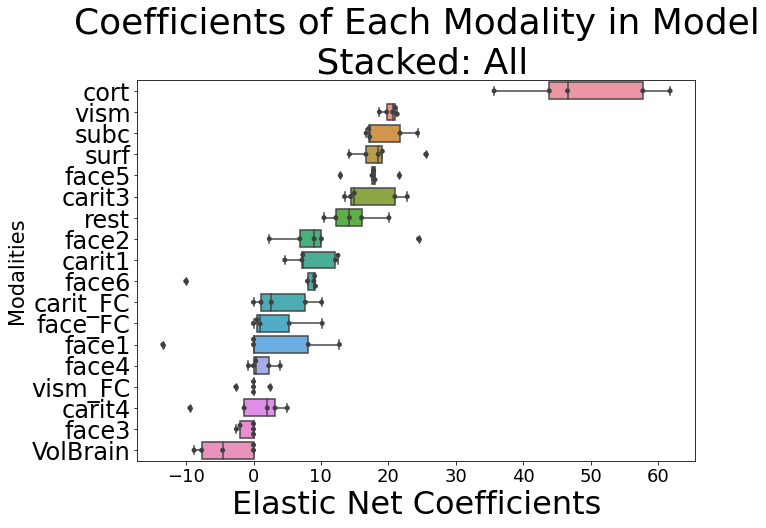

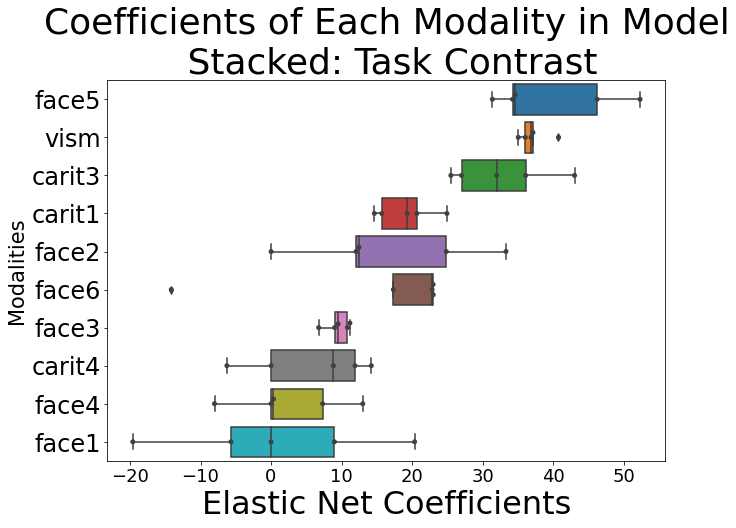

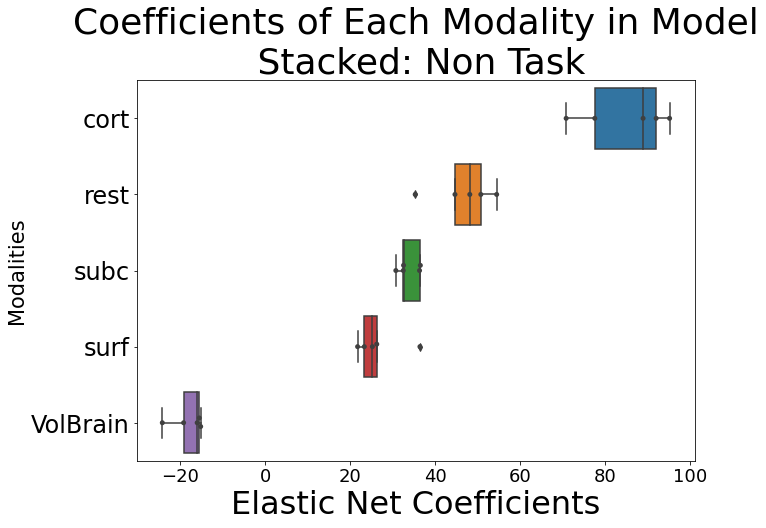

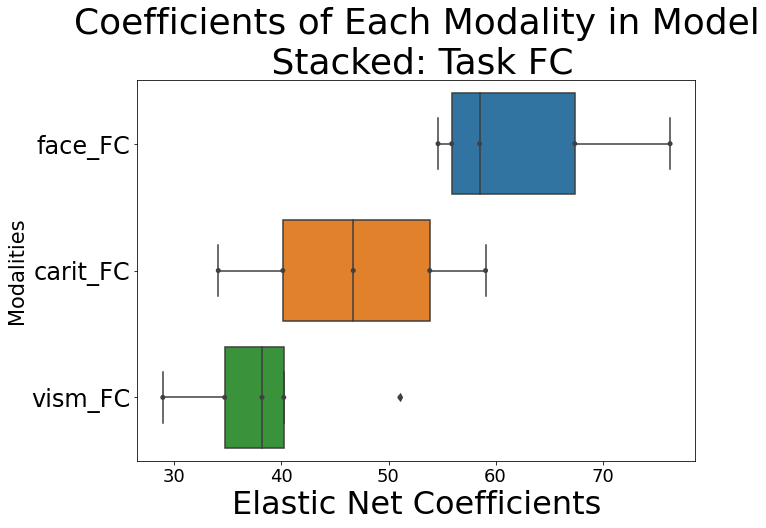

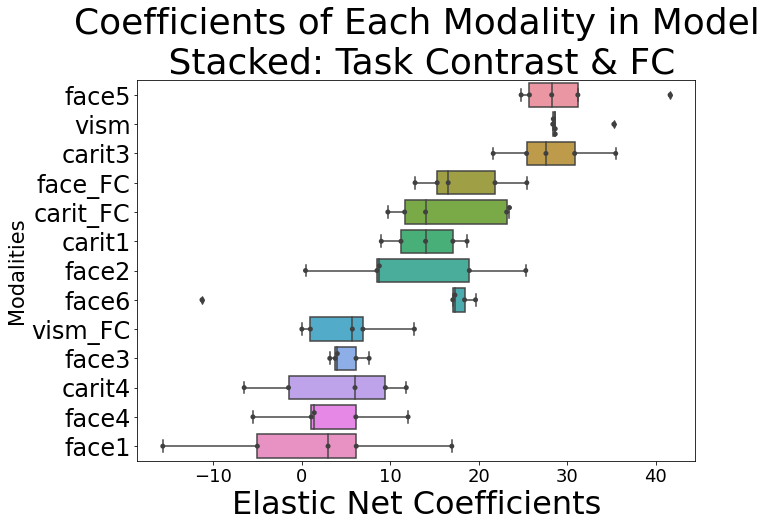

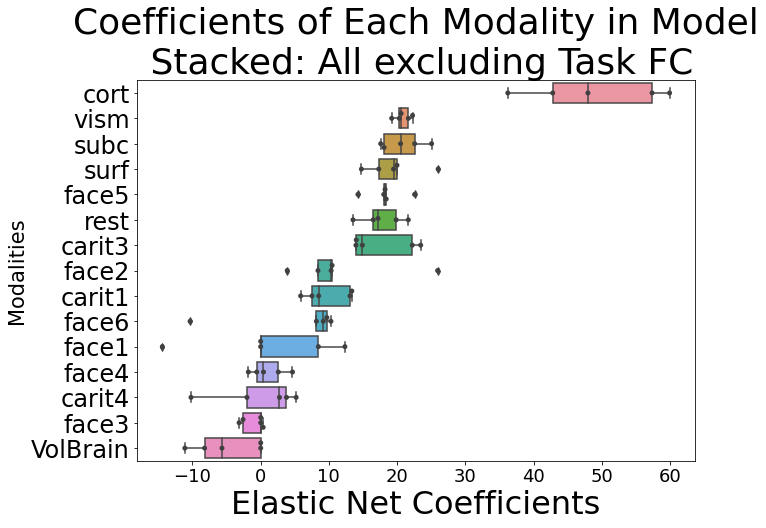

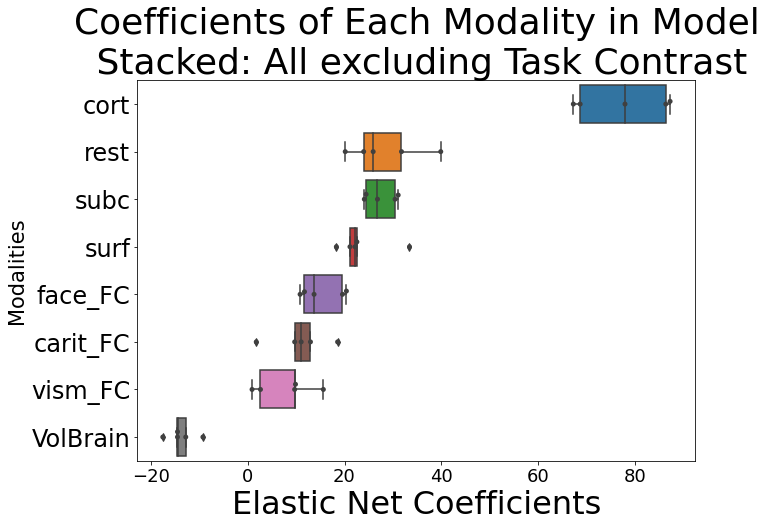

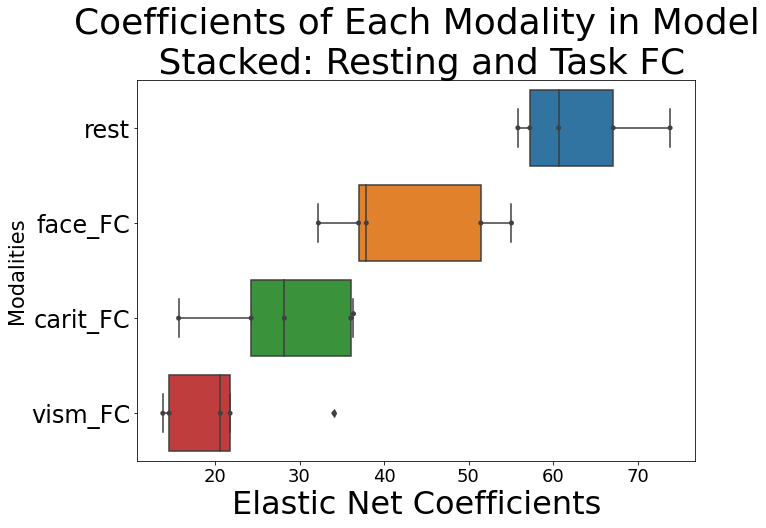

In [17]:
#plot stacked model coeffs 

for key, label in zip(dct_stack_coeff.keys(), lblY[-8:]):
    d=dct_stack_coeff[key].reindex(columns = dct_stack_coeff[key].mean().sort_values(ascending=False).index)

    plt.figure(figsize=(10,7))

    sns.boxplot(data=d, orient="h")
    sns.swarmplot(data=d, color=".25", orient="h")

    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=24)
    plt.xlabel('Elastic Net Coefficients', fontsize=32)
    plt.ylabel('Modalities', fontsize=21)
    plt.title('Coefficients of Each Modality in Model\n '+label ,fontsize=36)

    plt.show()

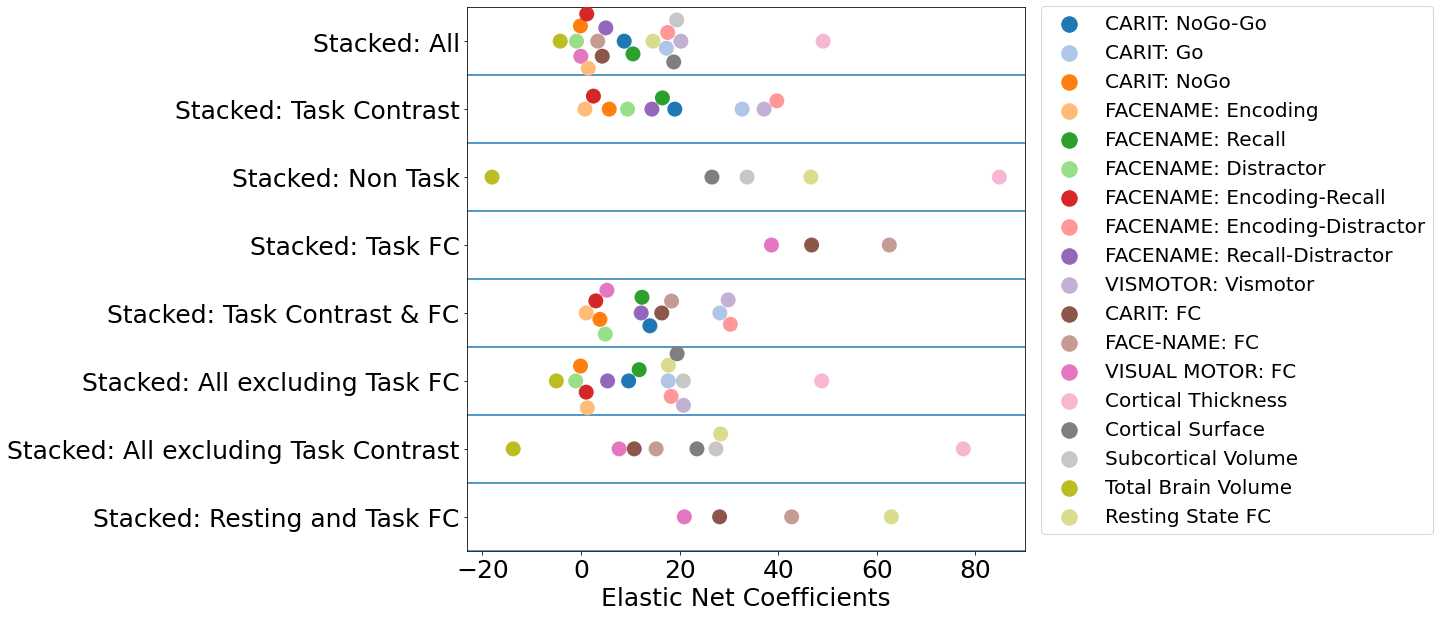

In [18]:
#Plot stacked model coefficients in different way

#non-std coefficients

#calculate mean for each stacking set
dct_mean_stack_coef = {}
for key in dct_stack_coeff.keys():
    dct_mean_stack_coef[key] = dct_stack_coeff[key].mean()
df_mean_stack_coef = pd.DataFrame(dct_mean_stack_coef)
df_mean_stack_coef = df_mean_stack_coef.reindex(index = dct_mean_stack_coef['set1'].index)
df_mean_stack_coef.index = lblY[:-8] 
df_mean_stack_coef.columns = lblY[-8:]

#reshape
df_plot_ = pd.DataFrame()
for col in df_mean_stack_coef.columns:
    vct = df_mean_stack_coef[col].values
    ind = df_mean_stack_coef[col].index
    sst = np.full(len(ind), col)
    df__ = pd.DataFrame({'val':vct, 'mod':ind, 'set':sst})
    df_plot_ = pd.concat([df_plot_, df__], axis=0, ignore_index=True)
    
#plot
plt.figure(figsize=(10,10))
sns.swarmplot(data=df_plot_, x='val', y='set', hue='mod', orient="h", 
              palette="tab20", size=15)
for i in np.arange(0.5,9,1):
    plt.axhline(y=i)
plt.legend(loc='upper right', bbox_to_anchor=(1.75,1.02), fontsize=20, markerscale=2)
plt.xlabel('Elastic Net Coefficients', fontsize=25)
plt.ylabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

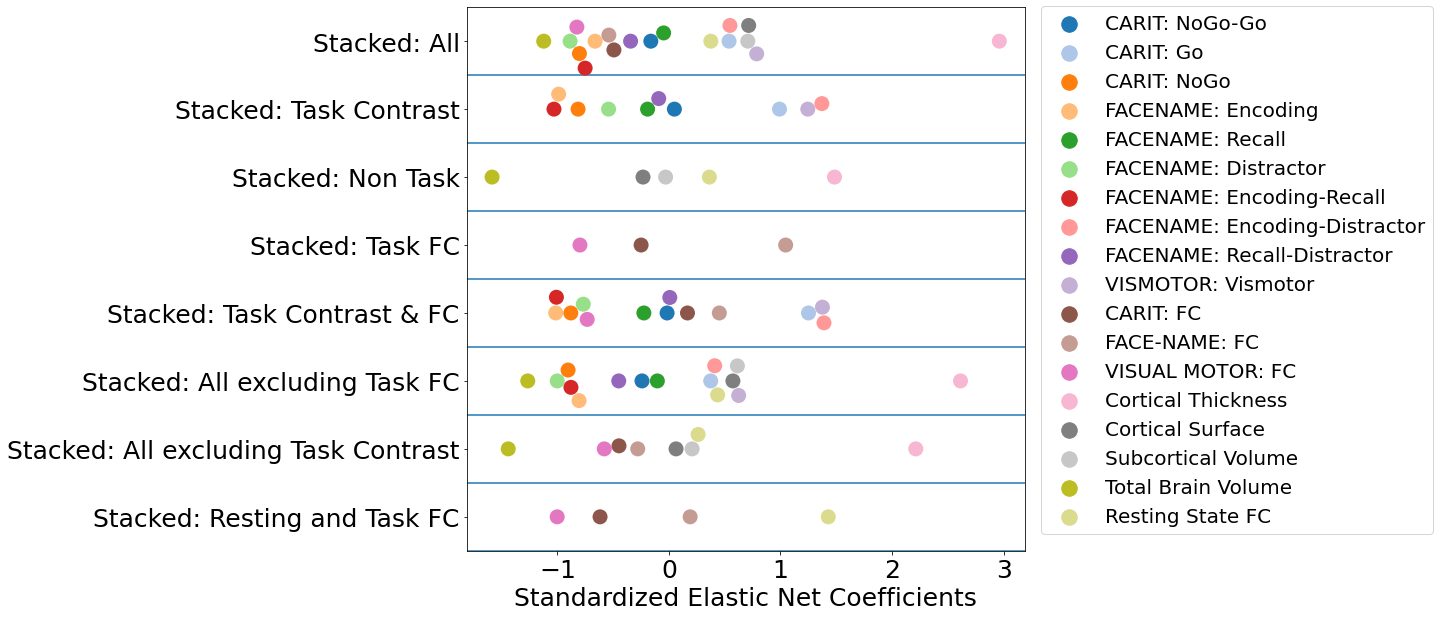

In [20]:
#Plot stacked model coefficients in different way

#standardize each fold feature before plotting

#calculate mean for each stacking set
#+ std feature each fold

dct_mean_stack_coef = {}
for key in dct_stack_coeff.keys():
    dct_mean_stack_coef[key] = pd.DataFrame(StandardScaler().fit_transform(dct_stack_coeff[key].T.values), 
                                            index=dct_stack_coeff[key].T.index, 
                                            columns=dct_stack_coeff[key].T.columns).T.mean()
df_mean_stack_coef = pd.DataFrame(dct_mean_stack_coef)
df_mean_stack_coef = df_mean_stack_coef.reindex(index = dct_mean_stack_coef['set1'].index)
df_mean_stack_coef.index = lblY[:-8] 
df_mean_stack_coef.columns = lblY[-8:]

#reshape
df_plot_ = pd.DataFrame()
for col in df_mean_stack_coef.columns:
    vct = df_mean_stack_coef[col].values
    ind = df_mean_stack_coef[col].index
    sst = np.full(len(ind), col)
    df__ = pd.DataFrame({'val':vct, 'mod':ind, 'set':sst})
    df_plot_ = pd.concat([df_plot_, df__], axis=0, ignore_index=True)
    
#plot
plt.figure(figsize=(10,10))
sns.swarmplot(data=df_plot_, x='val', y='set', hue='mod', orient="h", 
              palette="tab20", size=15)
for i in np.arange(0.5,9,1):
    plt.axhline(y=i)
plt.legend(loc='upper right', bbox_to_anchor=(1.75,1.02), fontsize=20, markerscale=2)
plt.xlabel('Standardized Elastic Net Coefficients', fontsize=25)
plt.ylabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [21]:
#save table used for upper plotting (with std coeffs)
df_plot_.to_csv(path2+'table_plot_stack_coeff_age.csv')

In [22]:
#save each modality mean feature coefficients as vector to txt
for key in dct_mean_stack_coef.keys():
    dct_mean_stack_coef[key].to_csv(path2+str(key)+'_Stack_mean_std_elnet_coeffs.txt', header=None)

#### Feature coefficients for single modality models

In [25]:
#extract feature importance from saved models

#for single modalities (except functional connectivities)


dct_elnet_coeff={}

for file in [i.split('/')[-1] for i in sorted(glob.glob(path2+fold+'/*_elnet_model.sav'))]:
    
    if ('_FC_' not in file) and ('rest' not in file):
        
        dct_ = {}
        #extracting feature importance for each fold each modality
        for fold in folders:
            dct_[fold] = (joblib.load(path2+fold+'/'+file)).named_steps['elasticnet'].coef_
        #assign appropriate indexes
        if file.split('_')[0] in ['carit1','carit3','carit4','face1',
                                  'face2','face3','face4','face5','face6','vism']:
            indxs = ind_task
        elif file.split('_')[0] in ['cort', 'surf']:
            indxs = ind_anat
        elif file.split('_')[0] in ['subc']:
            indxs = ind_subc
        elif file.split('_')[0] in ['VolBrain']:    
            indxs = ind_bVol   
            
        df = pd.DataFrame(dct_ , index=indxs).T 
        #save as csv table
        df.to_csv(path2+file.split('_')[0]+'_elnet_coeffs.csv')
        #save to dictionary
        dct_elnet_coeff[file.split('_')[0]] = df

In [26]:
#extract feature importance from saved models

#for single modalities, only functional connectivities


dct_elnet_FC_coeff={}

for file in [i.split('/')[-1] for i in sorted(glob.glob(path2+fold+'/*_elnet_model.sav'))]:
    
    if ('_FC_' in file) or ('rest'  in file):
        
        dct_ = {}
        #assign appropriate indexes
        indxs = ind_FC
        colsx = np.arange(1,76,1)
        #extracting feature importance for each fold each modality
        for fold in folders:
            #extract PCA values (~71000 of ROI pairs into 75 pc)
            pca_model_ind = np.absolute(((joblib.load(path2+fold+'/PCA_models/PCA_model.sav'))[file.replace("_elnet_model.sav", '')]).components_)
            #extract ElasticNet values for 75 pc
            pc_inx = (joblib.load(path2+fold+'/'+file)).named_steps['elasticnet'].coef_
            #multiply PCA values with ElNet values, and summarize across 75 pc for each ROI pair, for one fold
            dct_[fold] = pd.DataFrame( pca_model_ind.T * pc_inx , index = indxs, columns = colsx).T.sum()  
            
        df = pd.DataFrame(dct_).T
        #save as csv table
        df.to_csv(path2+file.replace("_elnet_model.sav", '')+'_elnet_coeffs.csv')
        #save to dictionary
        dct_elnet_FC_coeff[file.replace("_elnet_model.sav", '')] = df

##### Plotting single modality feature importances

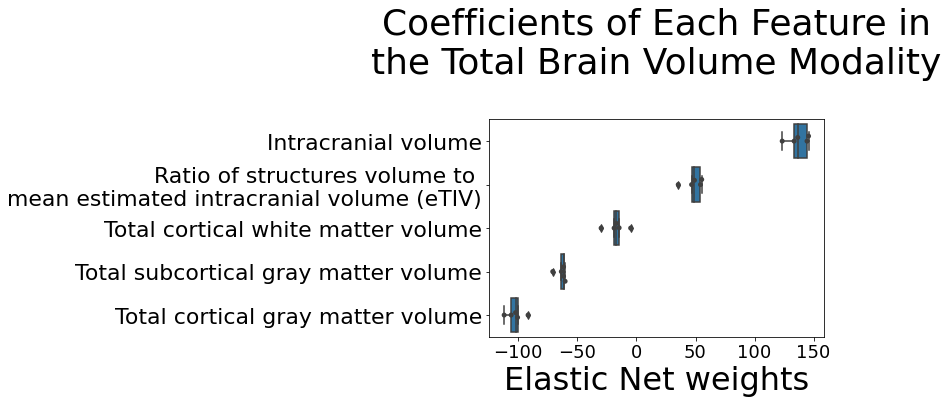

In [28]:
#Total Brain Volume

#non-std coefficients

data = dct_elnet_coeff['VolBrain']
data.columns = ['Intracranial volume',
'Total cortical gray matter volume',
'Total subcortical gray matter volume',
'Total cortical white matter volume',
'Ratio of structures volume to \nmean estimated intracranial volume (eTIV)']

data = data.loc[:, data.mean().sort_values(ascending=False).index]
sns.boxplot(data=data, orient="h", color='tab:blue')
sns.swarmplot(data=data, color=".25", orient="h")

plt.xticks(fontsize=18)
plt.yticks(fontsize=22)
#plt.xlabel('', fontsize=21)
plt.xlabel('Elastic Net weights', fontsize=32)
plt.title('Coefficients of Each Feature in\nthe Total Brain Volume Modality\n',fontsize=36)

plt.show()

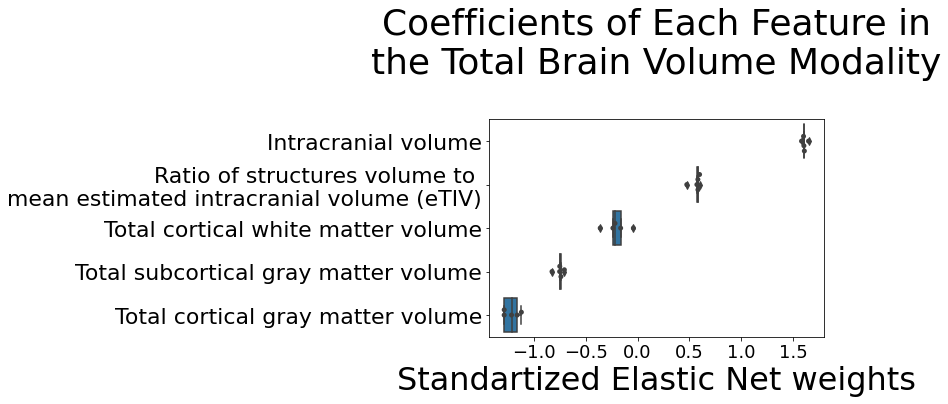

In [29]:
#Total Brain Volume

#std coefficients

data = dct_elnet_coeff['VolBrain']
data.columns = ['Intracranial volume',
'Total cortical gray matter volume',
'Total subcortical gray matter volume',
'Total cortical white matter volume',
'Ratio of structures volume to \nmean estimated intracranial volume (eTIV)']

data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                    index=data.T.index, columns=data.T.columns).T

data = data.loc[:, data.mean().sort_values(ascending=False).index]
sns.boxplot(data=data, orient="h", color='tab:blue')
sns.swarmplot(data=data, color=".25", orient="h")

plt.xticks(fontsize=18)
plt.yticks(fontsize=22)
#plt.xlabel('', fontsize=21)
plt.xlabel('Standartized Elastic Net weights', fontsize=32)
plt.title('Coefficients of Each Feature in\nthe Total Brain Volume Modality\n',fontsize=36)

plt.show()

In [31]:
#save each modality mean feature coefficients as vector to txt (for cifti)
key='VolBrain'
data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)

##### Tasks

carit1


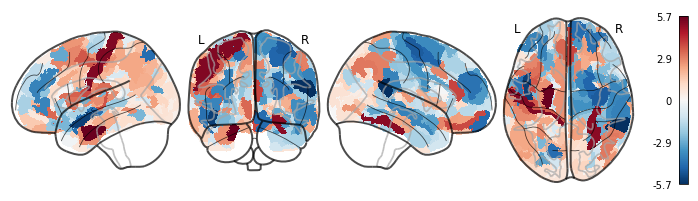

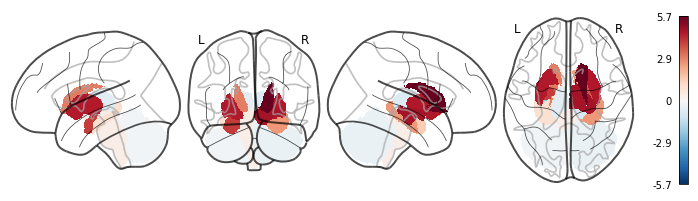

carit3


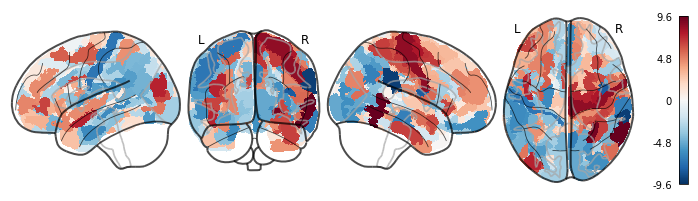

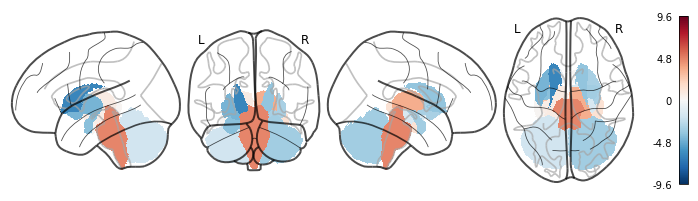

carit4


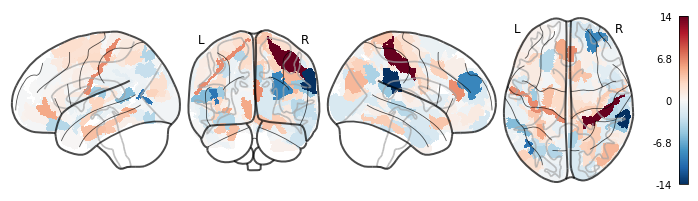

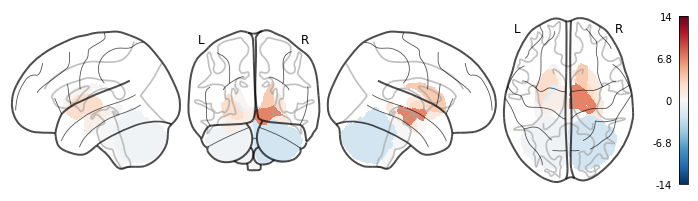

face1


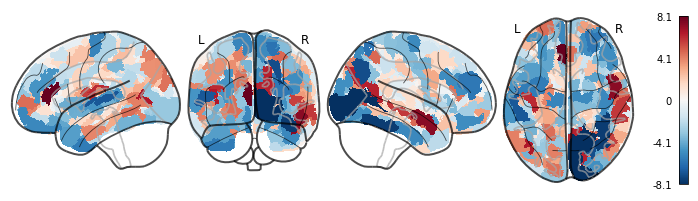

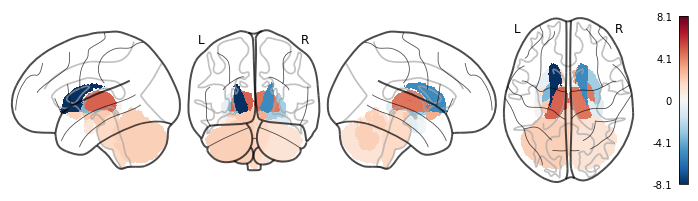

face2


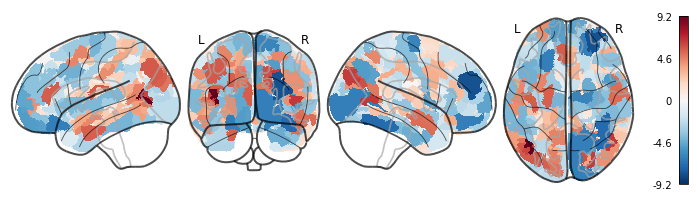

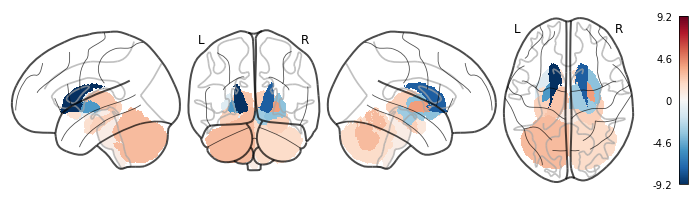

face3


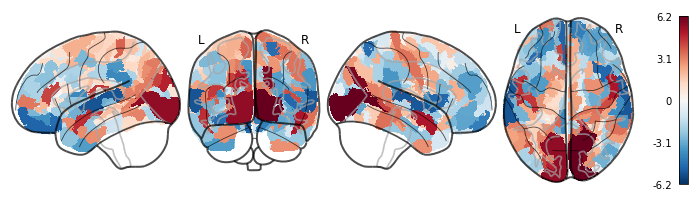

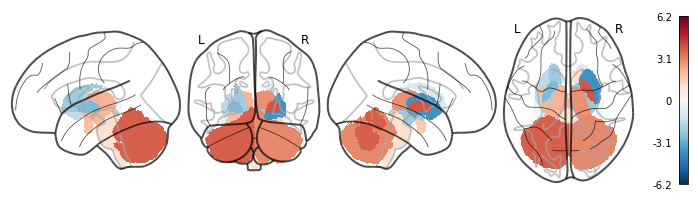

face4


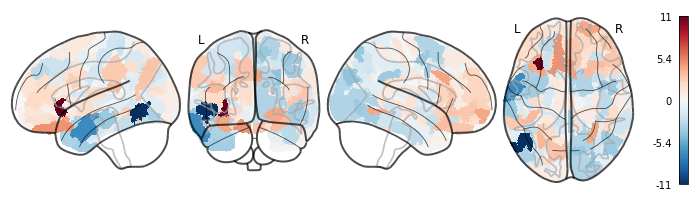

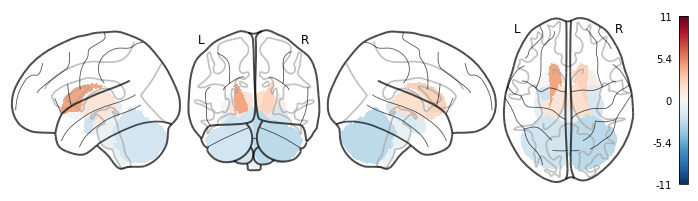

face5


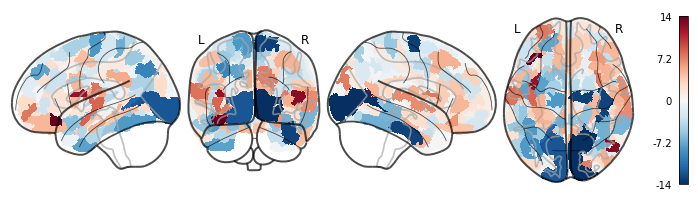

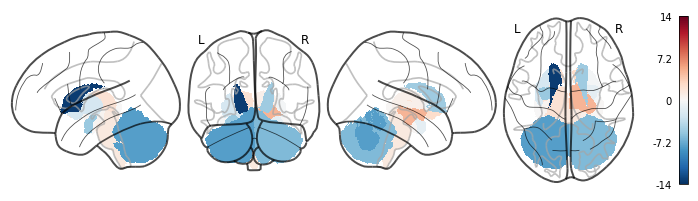

face6


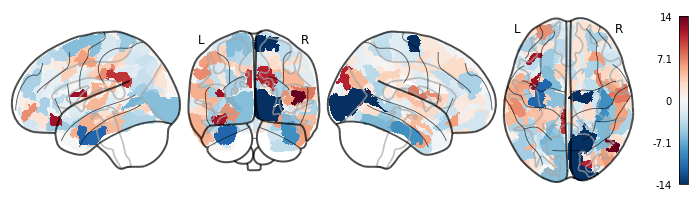

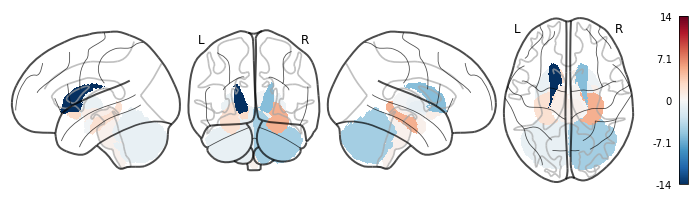

vism


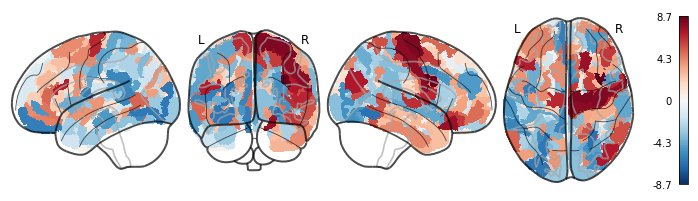

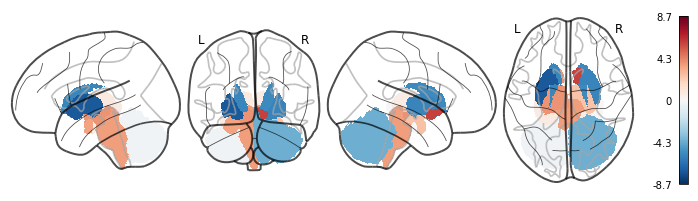

In [32]:
#plot task contrasts on brain

#non-std feature coefficients

#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()


for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']: #contrasts only
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    vec = pd.Series(np.concatenate( [(data.mean()[180:360]).values, np.zeros(20), (data.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((data.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                        colorbar=True, display_mode='lyrz', 
                                        vmin=min(data.mean()), vmax=max(data.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(data.mean()), vmax=max(data.mean()))
    plotting.show()

In [33]:
#standardize each fold feature before plotting

carit1


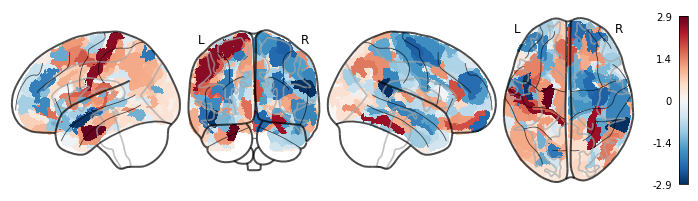

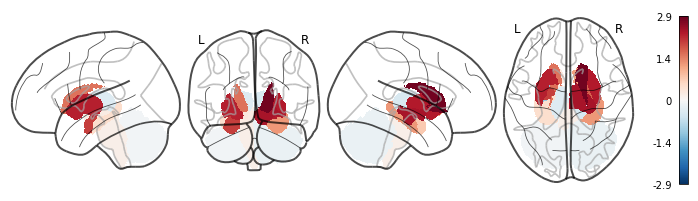

carit3


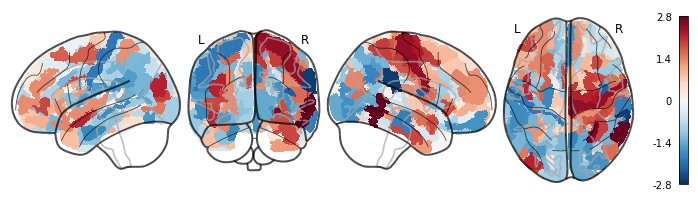

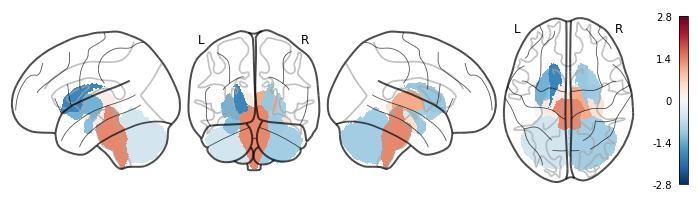

carit4


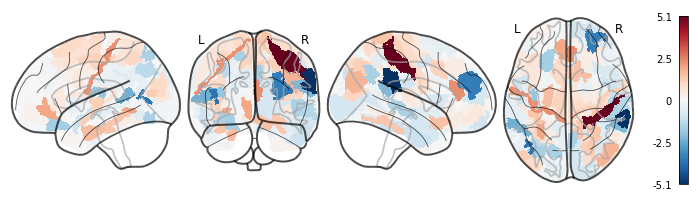

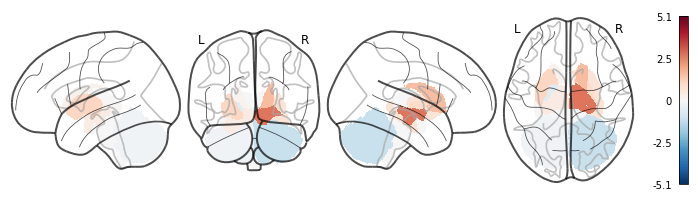

face1


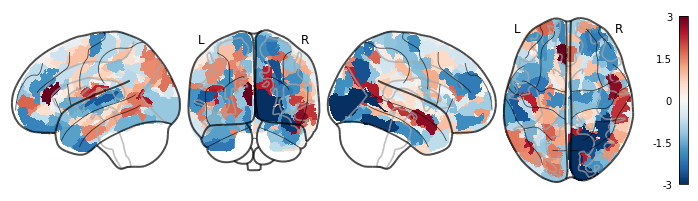

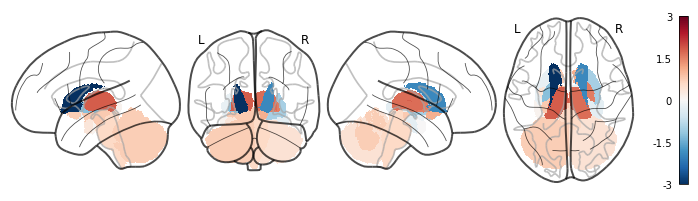

face2


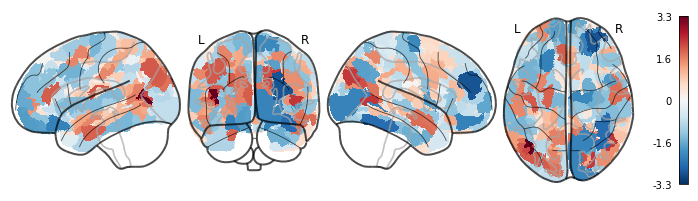

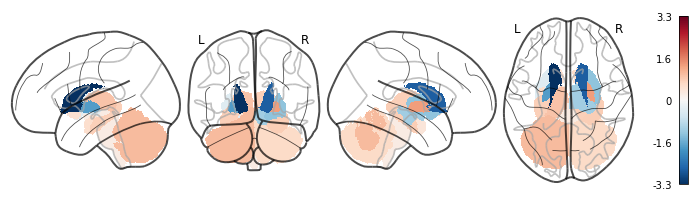

face3


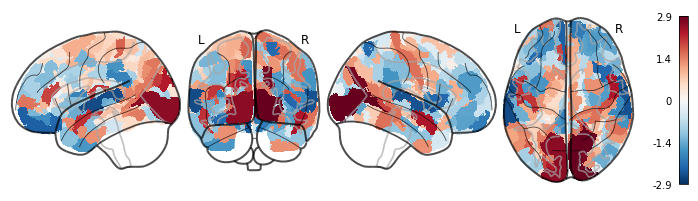

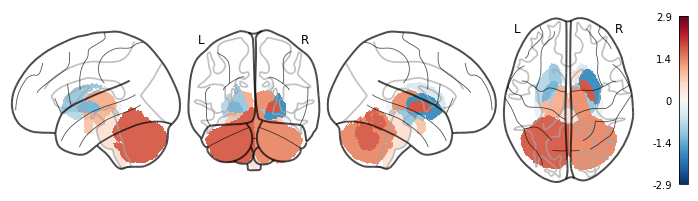

face4


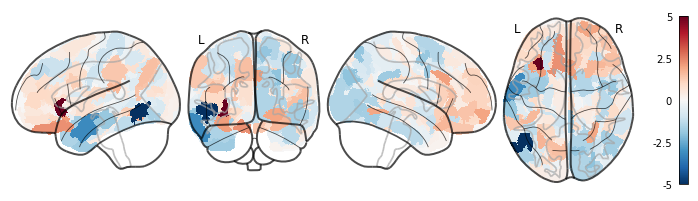

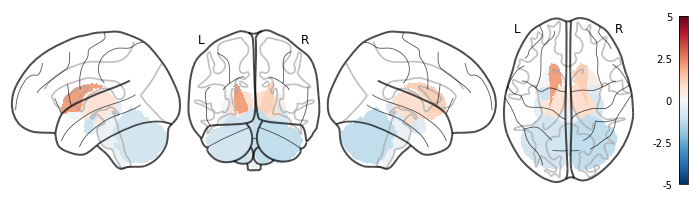

face5


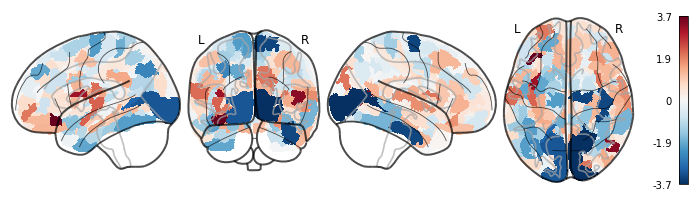

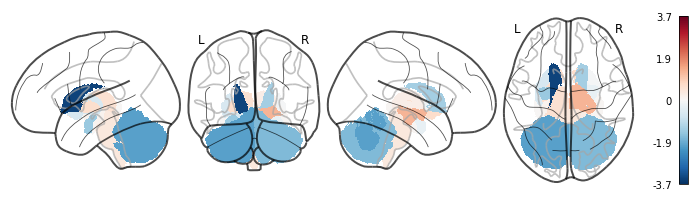

face6


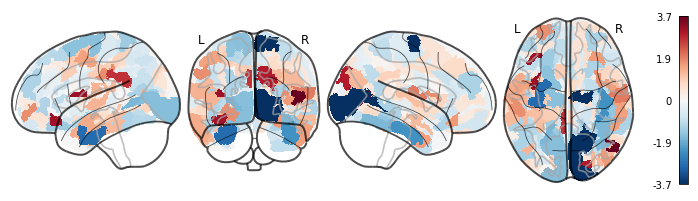

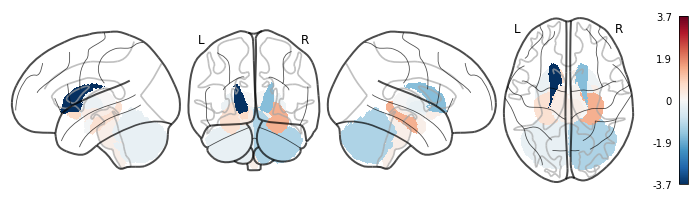

vism


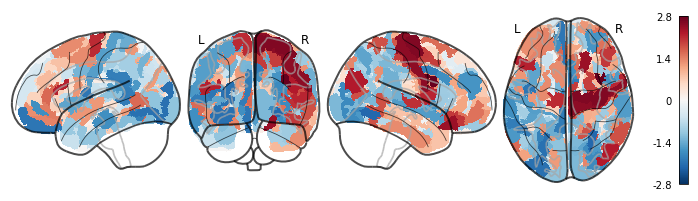

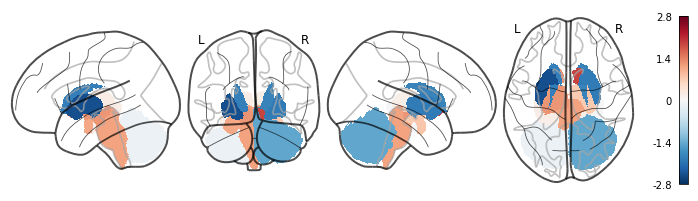

In [36]:
#plot task contrasts on brain

#std feature coefficients

#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()


for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']: #contrasts only
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]
    #std dataframe
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T    
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    vec = pd.Series(np.concatenate( [(data.mean()[180:360]).values, np.zeros(20), (data.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((data.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                        colorbar=True, display_mode='lyrz', 
                                        vmin=min(data.mean()), vmax=max(data.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(data.mean()), vmax=max(data.mean()))
    plotting.show()

carit1


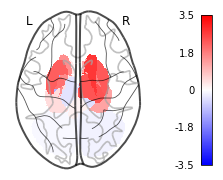

carit3


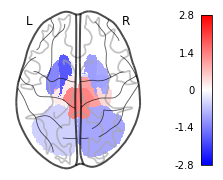

carit4


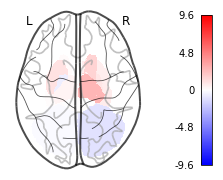

face1


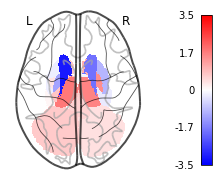

face2


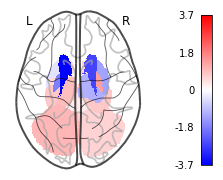

face3


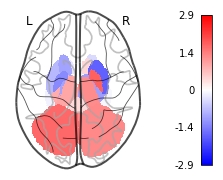

face4


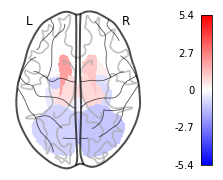

face5


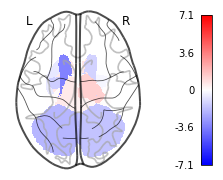

face6


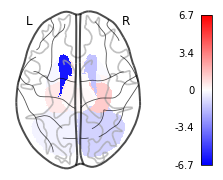

vism


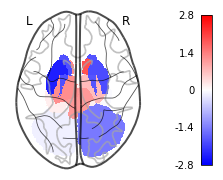

In [37]:
#plot task contrasts on one brain projection, subcortex only

#std feature coefficients


#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

#par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()


for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']: #contrasts only
    #empty image in the same way as reffered atlas
    #site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]
    #std dataframe
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T    
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    #vec = pd.Series(np.concatenate( [(data.mean()[180:360]).values, np.zeros(20), (data.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((data.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    #for index, numb in enumerate(vec): 
    #    site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    #site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    #display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
    #                                    colorbar=True, display_mode='lyrz', 
    #                                    vmin=min(data.mean()), vmax=max(data.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='bwr',        #different colormap
                                         colorbar=True, display_mode='z', 
                                         vmin=min(data.mean()), 
                                         vmax=round(max(max(data.mean()), abs(min(data.mean()))), 2))
    plotting.show()

In [38]:
#save each modality mean feature coefficients as vector to txt for next plotting (cifti)

for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']:
    #std
    data = dct_elnet_coeff[key]
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T
    #save txt
    data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)
    data.mean()[0:360].to_csv(path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt', header=None, index=None)
    
    #cifti
    cmd = 'wb_command -cifti-convert -from-text '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt'+' '+wway+'glasser_cifti_empty_template.ptseries.nii' +' '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs.ptseries.nii'
    os.system(cmd)

##### Anatomical (Non-Tasks) Modalities

In [40]:
#assign roi labels, add extra labels for plotting

new_str_ind = list(dct_elnet_coeff['cort'].mean().index)
new_str_ind.insert(41, 'lh_medial_wall')
new_str_ind.insert(116, 'rh_medial_wall')


cort


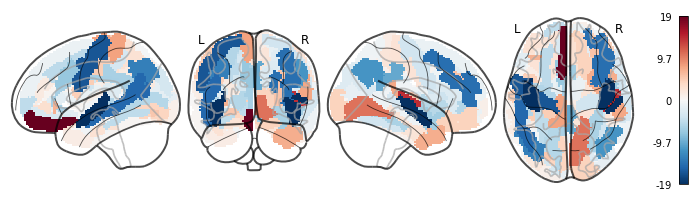

surf


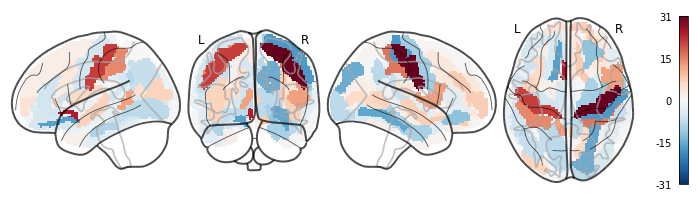

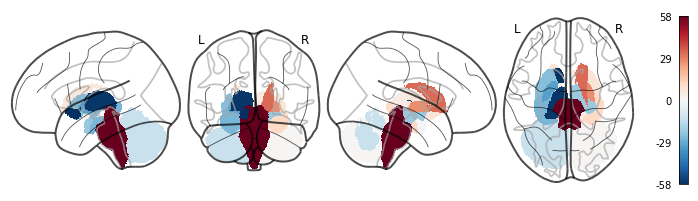

In [41]:
#plot anatomical cortical and subcortical feature importance (from FreeSurfer, Destrieux atlas)

#non-std

#load atlases
atlas = nli.load_img(wway+'destrieux2009_rois_lateralized.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()

#cortex

for key in ['cort', 'surf']:
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]#.reindex(columns=new_str_ind).fillna(0)
    #add to columns the med.wall label to match with nii atlas order
    vec = data.mean().reindex(index=new_str_ind).fillna(0)
    vec.index = np.loadtxt(wway+'destrieux2009_new_header_for_table_with_med_wall.txt',dtype=str)
    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)
    #display
    print(key)
    display_fs = plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                           colorbar=True, display_mode='lyrz', 
                                           vmin=min(vec), vmax=max(vec))
    plotting.show()

    
#subcortex

#empty image in the same way as reffered atlas
par_dat2 = atlas2.get_fdata()
site_nii2 = np.zeros(par_dat2.shape)
#reorder subc table into atlas order
v2 = dct_elnet_coeff['subc'].mean()
vec2 =pd.Series(v2.values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )
#fill mat with numbers
for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb
#create image object
site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
#display
print('subc')
display_subc = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(vec2), vmax=max(vec2))
plotting.show()

In [42]:
#standardized coeffs

cort


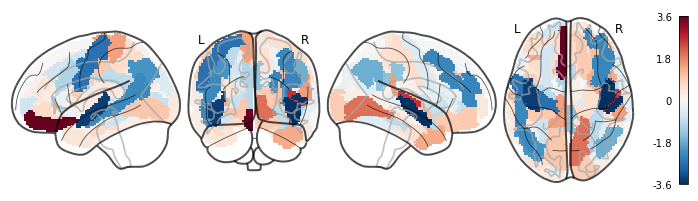

surf


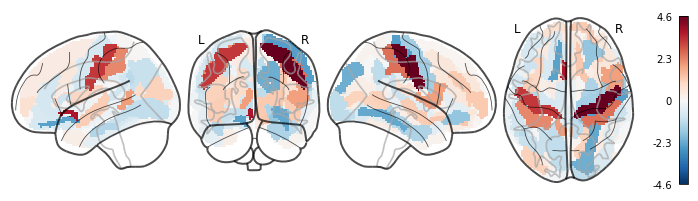

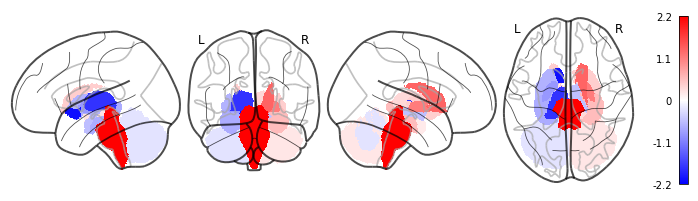

In [43]:
#plot anatomical cortical and subcortical feature importance (from FreeSurfer, Destrieux atlas)

#std

#load atlases
atlas = nli.load_img(wway+'destrieux2009_rois_lateralized.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()

#cortex

for key in ['cort', 'surf']:
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]#.reindex(columns=new_str_ind).fillna(0)
    #std
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T
    #add to columns the med.wall label to match with nii atlas order
    vec = data.mean().reindex(index=new_str_ind).fillna(0)
    vec.index = np.loadtxt(wway+'destrieux2009_new_header_for_table_with_med_wall.txt',dtype=str)
    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)
    #display
    print(key)
    display_fs = plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                           colorbar=True, display_mode='lyrz', 
                                           vmin=min(vec), vmax=max(vec))
    plotting.show()

    
#subcortex

#empty image in the same way as reffered atlas
par_dat2 = atlas2.get_fdata()
site_nii2 = np.zeros(par_dat2.shape)
#reorder subc table into atlas order
dtvc = dct_elnet_coeff['subc']
#std
dtvc = pd.DataFrame(StandardScaler().fit_transform(dtvc.T.values),
                    index=dtvc.T.index, columns=dtvc.T.columns).T
v2 = dtvc.mean()
vec2 =pd.Series(v2.values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )
#fill mat with numbers
for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb
#create image object
site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
#display
print('subc')
display_subc = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='bwr',  #different colormap
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(vec2), 
                                         vmax=round(max(max(vec2), abs(min(vec2))), 2))
plotting.show()

In [44]:
#save each modality mean feature coefficients as vector to txt for next plotting (cifti)

for key in  ['cort', 'surf']:
    
    #std
    data = dct_elnet_coeff[key]#.reindex(columns=new_str_ind).fillna(0)
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T
    
    #save txt
    data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)
    data.mean().to_csv(path2+'mean_'+str(key)+'_cortex_destrx_elnet_coeffs_nums.txt', header=None, index=None)
    
    #cifti
    cmd = 'wb_command -cifti-convert -from-text '+path2+'mean_'+str(key)+'_cortex_destrx_elnet_coeffs_nums.txt'+' '+wway+'Destrieux_cifti_empty_template.pscalar.nii' +' '+path2+'mean_'+str(key)+'_cortex_destrx_elnet_coeffs.pscalar.nii'
    os.system(cmd)

##### Resting State and Tasks FC

In [ ]:
#these features in standardized option only

In [46]:
#reorganize from pairs of ROIs back to matrix format

dct_FC_mat = {}
for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:
    #dataframe to convert
    data_i  = dct_elnet_FC_coeff[key]

    df_std_FC = pd.DataFrame()
    #standardize
    for indx in data_i.index:
        df_std_FC[indx] = pd.DataFrame(StandardScaler().fit_transform(data_i.loc[indx,:].values.reshape(-1, 1)), 
                                       index=data_i.loc[indx,:].index)[0]
    df_std_FC = df_std_FC.T
    
    #average across folds    
    data = df_std_FC.mean()

    #restore full matrix
    ind379 = np.triu_indices(379, k=1)
    mat379 = np.zeros((379,379),float)
    mat379[ind379]=data.values
    mat379_2 = pd.DataFrame(mat379).replace(0, np.nan)
    mat379_f = pd.DataFrame(np.where(mat379,mat379_2,mat379_2.T))
    mat379_f.index = ind_task
    mat379_f.columns = ind_task
    
    #save mat to dct
    dct_FC_mat[key] = mat379_f
    

rest


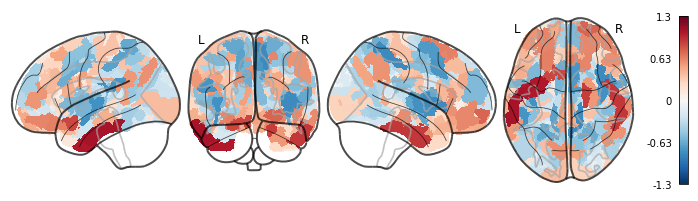

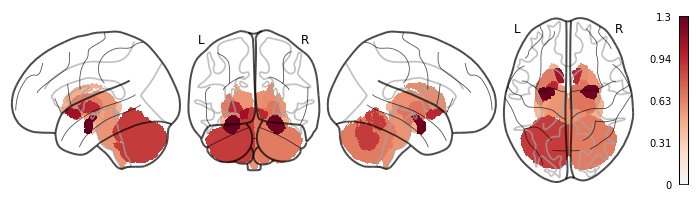

face_FC


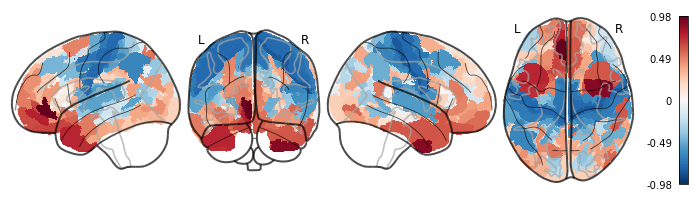

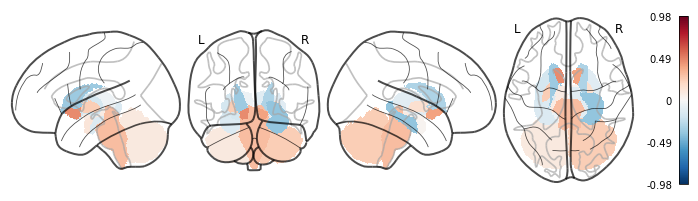

vism_FC


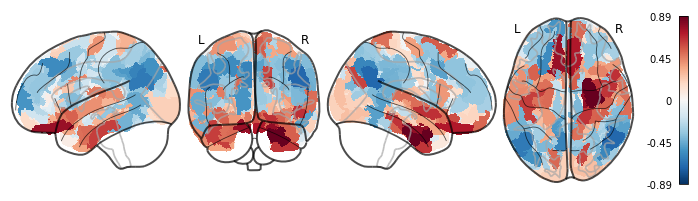

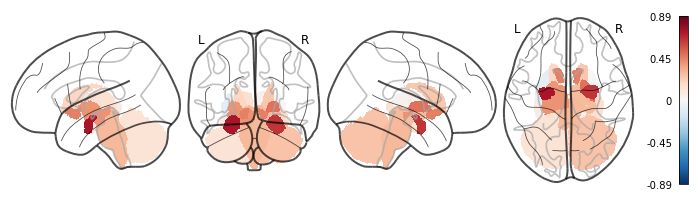

carit_FC


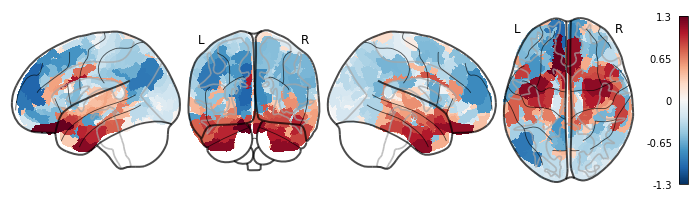

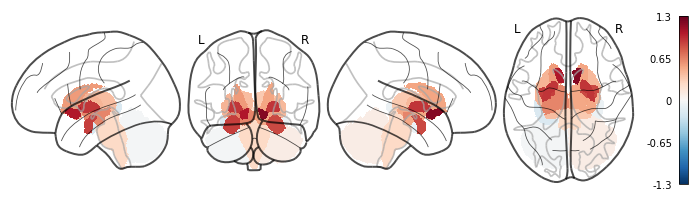

In [47]:
#plot FC values on brain

#already std

#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()

for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    dataFC = dct_FC_mat[key]
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    vec = pd.Series(np.concatenate( [(dataFC.mean()[180:360]).values, np.zeros(20), (dataFC.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((dataFC.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                        colorbar=True, display_mode='lyrz',
                                        vmin=min(dataFC.mean()), vmax=max(dataFC.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz',
                                         vmin=min(dataFC.mean()), vmax=max(dataFC.mean()))
    
    plotting.show()  

rest


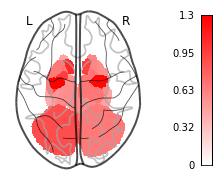

face_FC


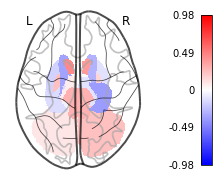

vism_FC


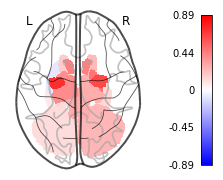

carit_FC


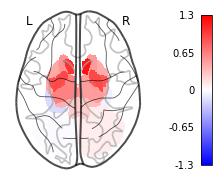

In [48]:
wway = '/media/DataD800/Alina/atlases/'

atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

#par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()



for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:

    #site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
       
    dataFC = dct_FC_mat[key]
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    #vec = pd.Series(np.concatenate( [(dataFC.mean()[180:360]).values, np.zeros(20), (dataFC.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((dataFC.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )


    #for index, numb in enumerate(vec): 
    #    site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb

    #site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    print(key)
    #display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
    #                                    colorbar=True, display_mode='lyrz',
    #                                    vmin=min(dataFC.mean()), vmax=max(dataFC.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='bwr', 
                                         colorbar=True, display_mode='z',
                                         vmin=min(dataFC.mean()), 
                                         vmax=round(max(max(dataFC.mean()), abs(min(dataFC.mean()))), 2))
    
    plotting.show()

In [49]:
#save each modality mean feature coefficients as vector to txt for next plotting (cifti)

for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:
    #std
    data = dct_FC_mat[key]

    #save txt
    data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)
    data.mean()[0:360].to_csv(path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt', header=None, index=None)
    
    #cifti
    cmd = 'wb_command -cifti-convert -from-text '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt'+' '+wway+'glasser_cifti_empty_template.ptseries.nii' +' '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs.ptseries.nii'
    os.system(cmd)